In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, sweep_poly
from librosa import cqt,stft
from librosa.feature import melspectrogram
import sys
sys.path.insert(0,'../')

import Spectrogram
import torch
import torch.nn as nn

In [2]:
cmap = 'jet'
fmin = 55 # for CQT use

fs = 44100
t = 1
f0 = 55
f1 = 22050

# Creating sin sweep

In [3]:
s = np.linspace(0,t, fs*t)

x = chirp(s, f0, 1, f1, method='logarithmic')
x = x.astype(dtype=np.float32)

# Comparing CQT results

Low pass filter created, time used = 0.0019 seconds
No early downsampling is required, downsample_factor =  1
Early downsampling filter created, time used = 0.0001 seconds
CQT kernels created, time used = 0.0051 seconds
STFT kernels created, time used = 0.0623 seconds


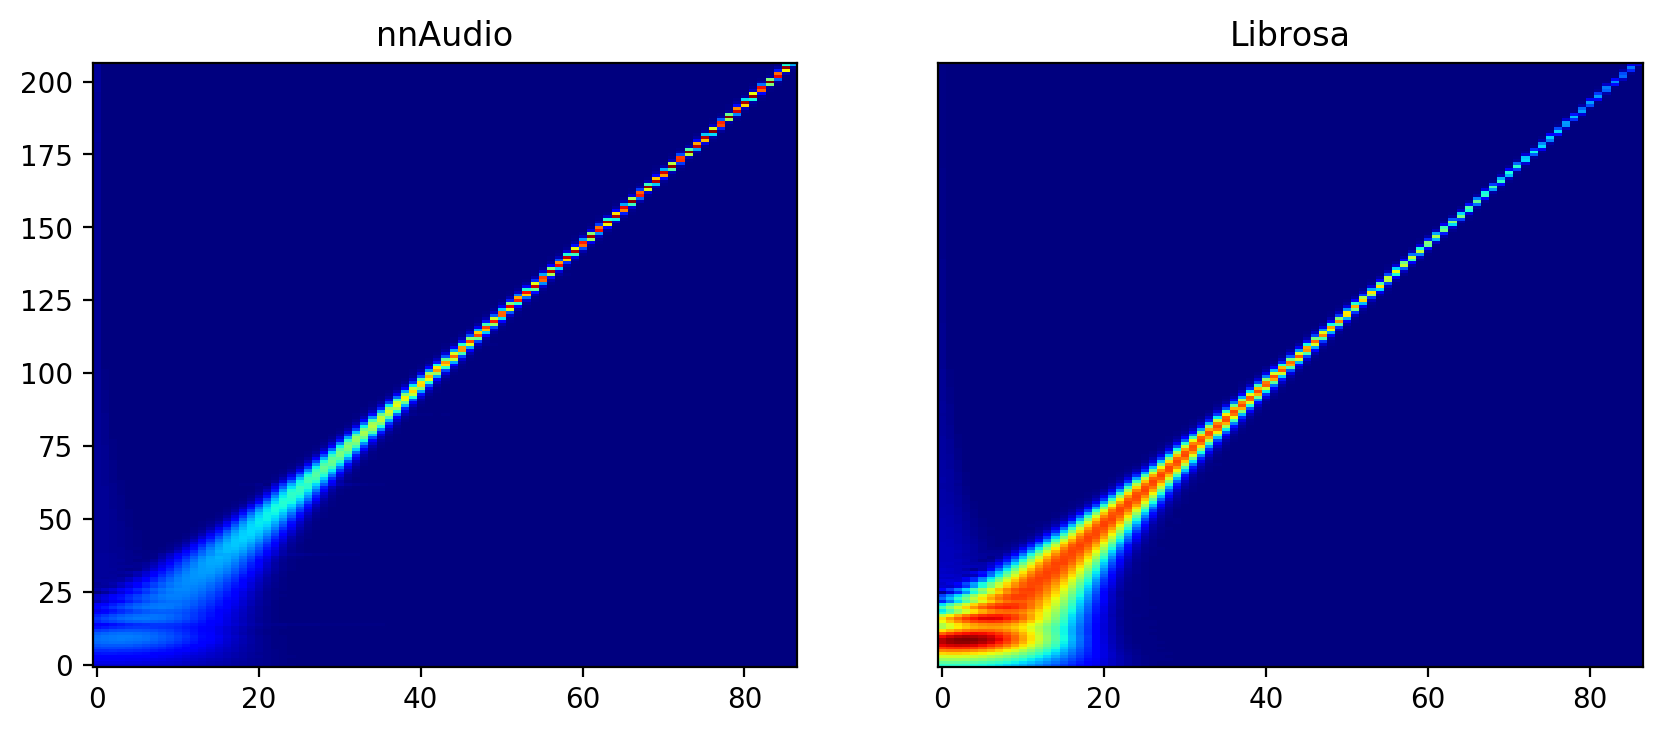

In [4]:
r=2
bins_per_octave = 12*r
n_bins = 104*r-1

CQT2010_layer = Spectrogram.CQT2010(fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='constant')
fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
cqt_x = CQT2010_layer(torch.tensor(x[None, None, :]))
output_lib1 = cqt(x, sr=fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='constant')
im1 = ax[0].imshow(cqt_x[0], aspect='auto', origin='lower', cmap=cmap)
im2 = ax[1].imshow(abs(output_lib1), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
# fig.colorbar(im1,ax=ax[0])
# fig.colorbar(im2,ax=ax[1])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

# Melspectrogram

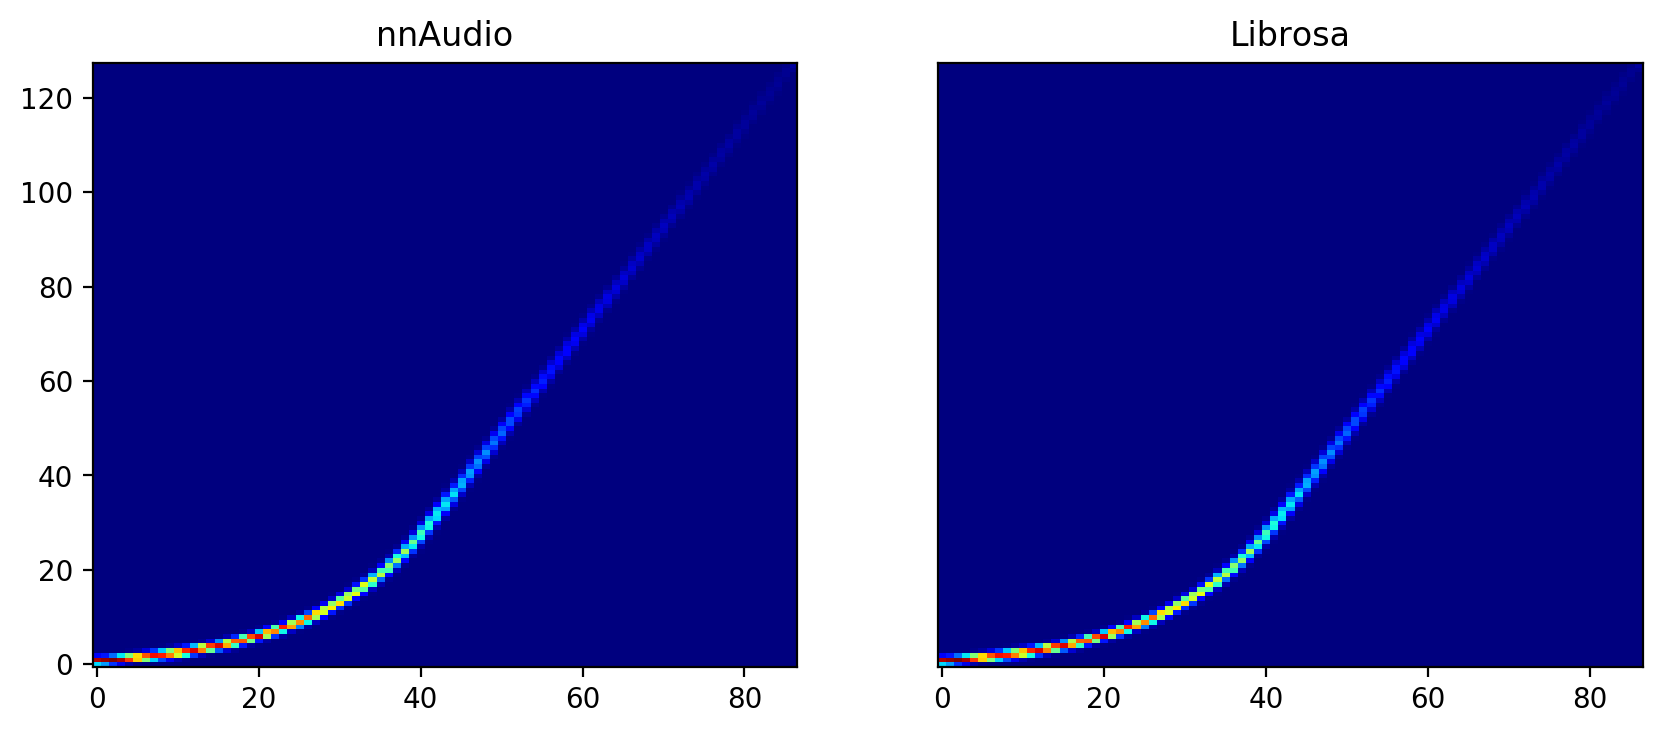

In [5]:
mel_layer = Spectrogram.MelSpectrogram(fs)
fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
mel_x_linear = mel_layer(torch.tensor(x[None, None, :]))
output_lib1 = melspectrogram(x, fs)
ax[0].imshow(mel_x_linear[0], aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(output_lib1, aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

In [6]:
print("Linear sweep all close ", np.allclose(mel_x_linear[0].numpy(), output_lib1, rtol=1e-4, atol=1e-4))

Linear sweep all close  True


# STFT linear freq

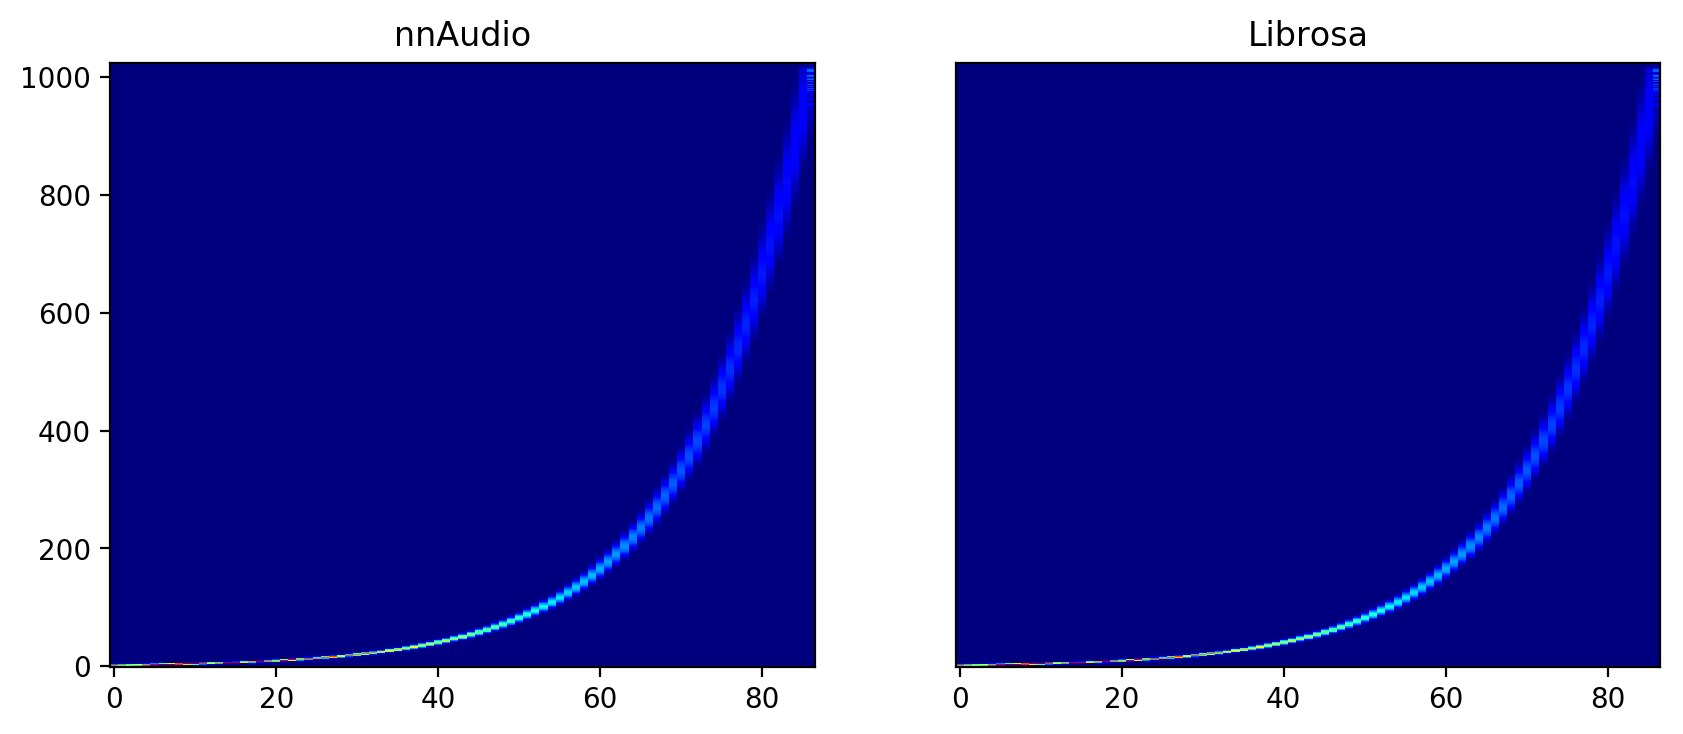

In [7]:
stft_layer_no = Spectrogram.STFT()
stft_x_linear = stft_layer_no(torch.tensor(x[None, None, :]))
output_lib1 = abs(stft(x))

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(stft_x_linear[0], aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(output_lib1, aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

In [8]:
print("Linear sweep all close ", np.allclose(stft_x_linear[0].numpy(), output_lib1, rtol=1e-4, atol=1e-4))

Linear sweep all close  True


# STFT log-freq

sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range


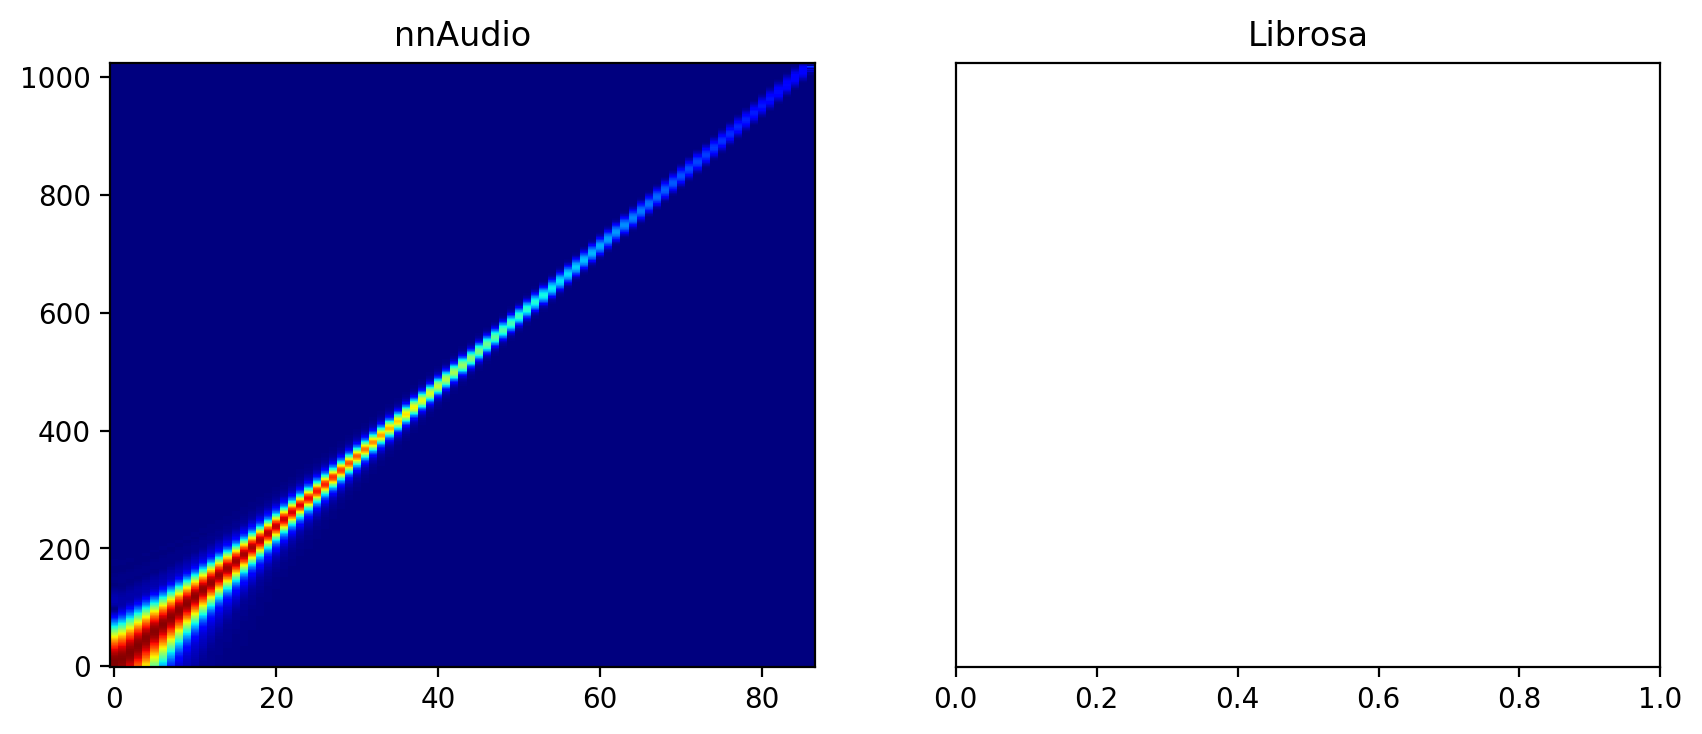

In [9]:
stft_layer = Spectrogram.STFT(freq_scale='log', fmin=55, fmax=22050, sr=44100)
stft_log_x_linear = stft_layer(torch.tensor(x[None, None, :]))

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(stft_log_x_linear[0], aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")